In [1]:
# Traffic prediction_length is 24. Reference:
# https://github.com/awslabs/gluonts/blob/6605ab1278b6bf92d5e47343efcf0d22bc50b2ec/src/gluonts/dataset/repository/_lstnet.py#L105

prediction_length = 24
context_length = prediction_length*2
batch_size = 128
num_batches_per_epoch = 100
epochs = 50
scaling = "std"


In [2]:
encoder_layers=2
decoder_layers=2
d_model=16

In [3]:
from gluonts.dataset.repository.datasets import get_dataset

dataset = get_dataset("traffic")
freq = dataset.metadata.freq
prediction_length = dataset.metadata.prediction_length


c:\Users\juhip\OneDrive\Desktop\enhancedts-transformers\.venv\Lib\site-packages\gluonts\json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [4]:
freq

'H'

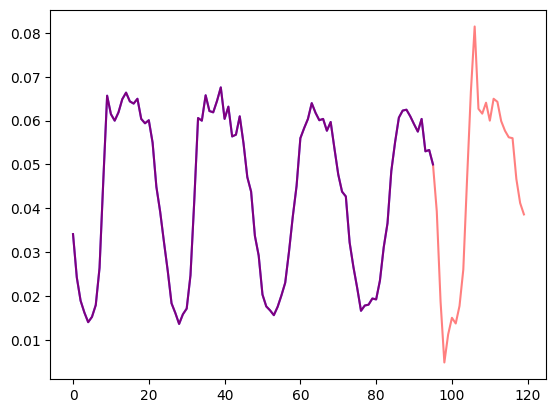

In [5]:
import matplotlib.pyplot as plt

train_example = next(iter(dataset.train))
test_example = next(iter(dataset.test))

num_of_samples = 4*prediction_length

figure, axes = plt.subplots()
axes.plot(train_example["target"][-num_of_samples:], color="blue")
axes.plot(
    test_example["target"][-num_of_samples - prediction_length :],
    color="red",
    alpha=0.5,
)

plt.show()


In [6]:
train_dataset = dataset.train
test_dataset = dataset.test


In [7]:
# FieldName.FEAT_AGE, FieldName.OBSERVED_VALUES,FieldName.FEAT_TIME, FieldName.TARGET

In [8]:
from transformers import PretrainedConfig
from gluonts.time_feature import time_features_from_frequency_str

from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)

def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    # create a list of fields to remove later
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in the life the value of the time series is
            # sort of running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )


c:\Users\juhip\OneDrive\Desktop\enhancedts-transformers\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
from gluonts.transform import InstanceSplitter
from gluonts.transform.sampler import InstanceSampler
from typing import Optional


def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )


In [10]:
from typing import Iterable

import torch
from gluonts.itertools import Cyclic, Cached
from gluonts.dataset.loader import as_stacked_batches


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from the 366 possible transformed time series)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(stream, is_train=True)

    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )

def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # we create a Test Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "test")

    # we apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )


In [11]:
from transformers import AutoformerConfig, AutoformerForPrediction

config = AutoformerConfig.from_pretrained("kashif/autoformer-traffic-hourly")
model = AutoformerForPrediction.from_pretrained("kashif/autoformer-traffic-hourly")

test_dataloader = create_test_dataloader(
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=64,
)

train_dataloader = create_test_dataloader(
    config=config,
    freq=freq,
    data=train_dataset,
    batch_size=1,
)


In [12]:
data = next(iter(train_dataset))
data

{'target': array([0.0048, 0.0072, 0.004 , ..., 0.053 , 0.0533, 0.05  ], dtype=float32),
 'start': Period('2015-01-01 00:00', 'H'),
 'feat_static_cat': array([0]),
 'item_id': 0}

In [13]:
batch = next(iter(train_dataloader))
batch['past_time_features'].shape, batch['past_values'].shape, batch['past_observed_mask'].shape, batch['future_time_features'].shape, 
# batch

(torch.Size([1, 769, 5]),
 torch.Size([1, 769]),
 torch.Size([1, 769]),
 torch.Size([1, 24, 5]))

In [14]:
from accelerate import Accelerator

accelerator = Accelerator()
device = accelerator.device
model.to(device)
model.eval()

forecasts_ = []
for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts_.append(outputs.sequences.cpu().numpy())


In [15]:
forecasts_[0].shape


(64, 100, 24)

In [16]:
import numpy as np

forecasts = np.vstack(forecasts_)
print(forecasts.shape)


(6034, 100, 24)


In [17]:
from tqdm.autonotebook import tqdm
from evaluate import load
from gluonts.time_feature import get_seasonality

mase_metric = load("evaluate-metric/mase")

forecast_median = np.median(forecasts, 1)

mase_metrics = []
for item_id, ts in enumerate(tqdm(test_dataset)):
    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]
    mase = mase_metric.compute(
        predictions=forecast_median[item_id], 
        references=np.array(ground_truth), 
        training=np.array(training_data), 
        periodicity=get_seasonality(freq))
    mase_metrics.append(mase["mase"])


100%|██████████| 6034/6034 [01:27<00:00, 69.23it/s]


In [18]:
print(f"Autoformer univariate MASE: {np.mean(mase_metrics):.3f}")

Autoformer univariate MASE: 0.910


In [19]:
import matplotlib.dates as mdates
import pandas as pd

test_ds = list(test_dataset)

def plot(ts_index):
    fig, ax = plt.subplots()

    index = pd.period_range(
        start=test_ds[ts_index][FieldName.START],
        periods=len(test_ds[ts_index][FieldName.TARGET]),
        freq=test_ds[ts_index][FieldName.START].freq,
    ).to_timestamp()

    ax.plot(
        index[-5*prediction_length:], 
        test_ds[ts_index]["target"][-5*prediction_length:],
        label="actual",
    )

    plt.plot(
        index[-prediction_length:], 
        np.median(forecasts[ts_index], axis=0),
        label="median",
    )
    
    plt.gcf().autofmt_xdate()
    plt.legend(loc="best")
    plt.show()


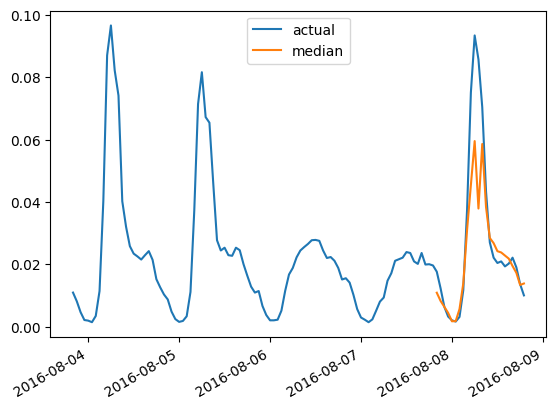

In [20]:
plot(4)


In [21]:
# from gluonts.torch.model.d_linear.estimator import DLinearEstimator
from gluonts.torch.model.d_linear import DLinearEstimator

# Define the DLinear model with the same parameters as the Autoformer model
estimator = DLinearEstimator(
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length*2,
    scaling=scaling,
    hidden_dimension=2,
    
    batch_size=batch_size,
    num_batches_per_epoch=num_batches_per_epoch,
    trainer_kwargs=dict(max_epochs=epochs)
)


In [22]:
predictor = estimator.train(
    training_data=train_dataset, 
    cache_data=True, 
    shuffle_buffer_length=1024
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
c:\Users\juhip\OneDrive\Desktop\enhancedts-transformers\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[

Epoch 0: |          | 100/? [00:05<00:00, 18.50it/s, v_num=5, train_loss=-2.16]

INFO: Epoch 0, global step 100: 'train_loss' reached -2.15544 (best -2.15544), saving model to 'c:\\Users\\juhip\\OneDrive\\Desktop\\enhancedts-transformers\\scripts\\EXP-LongForecasting\\lightning_logs\\version_5\\checkpoints\\epoch=0-step=100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 100: 'train_loss' reached -2.15544 (best -2.15544), saving model to 'c:\\Users\\juhip\\OneDrive\\Desktop\\enhancedts-transformers\\scripts\\EXP-LongForecasting\\lightning_logs\\version_5\\checkpoints\\epoch=0-step=100.ckpt' as top 1


Epoch 1: |          | 100/? [00:03<00:00, 25.48it/s, v_num=5, train_loss=-2.41]

INFO: Epoch 1, global step 200: 'train_loss' reached -2.41293 (best -2.41293), saving model to 'c:\\Users\\juhip\\OneDrive\\Desktop\\enhancedts-transformers\\scripts\\EXP-LongForecasting\\lightning_logs\\version_5\\checkpoints\\epoch=1-step=200.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 200: 'train_loss' reached -2.41293 (best -2.41293), saving model to 'c:\\Users\\juhip\\OneDrive\\Desktop\\enhancedts-transformers\\scripts\\EXP-LongForecasting\\lightning_logs\\version_5\\checkpoints\\epoch=1-step=200.ckpt' as top 1


Epoch 2: |          | 100/? [00:03<00:00, 25.93it/s, v_num=5, train_loss=-2.57]

INFO: Epoch 2, global step 300: 'train_loss' reached -2.56613 (best -2.56613), saving model to 'c:\\Users\\juhip\\OneDrive\\Desktop\\enhancedts-transformers\\scripts\\EXP-LongForecasting\\lightning_logs\\version_5\\checkpoints\\epoch=2-step=300.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 300: 'train_loss' reached -2.56613 (best -2.56613), saving model to 'c:\\Users\\juhip\\OneDrive\\Desktop\\enhancedts-transformers\\scripts\\EXP-LongForecasting\\lightning_logs\\version_5\\checkpoints\\epoch=2-step=300.ckpt' as top 1


Epoch 3: |          | 100/? [00:03<00:00, 26.50it/s, v_num=5, train_loss=-2.70]

INFO: Epoch 3, global step 400: 'train_loss' reached -2.70305 (best -2.70305), saving model to 'c:\\Users\\juhip\\OneDrive\\Desktop\\enhancedts-transformers\\scripts\\EXP-LongForecasting\\lightning_logs\\version_5\\checkpoints\\epoch=3-step=400.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 400: 'train_loss' reached -2.70305 (best -2.70305), saving model to 'c:\\Users\\juhip\\OneDrive\\Desktop\\enhancedts-transformers\\scripts\\EXP-LongForecasting\\lightning_logs\\version_5\\checkpoints\\epoch=3-step=400.ckpt' as top 1


Epoch 4: |          | 100/? [00:03<00:00, 26.36it/s, v_num=5, train_loss=-2.82]

INFO: Epoch 4, global step 500: 'train_loss' reached -2.81581 (best -2.81581), saving model to 'c:\\Users\\juhip\\OneDrive\\Desktop\\enhancedts-transformers\\scripts\\EXP-LongForecasting\\lightning_logs\\version_5\\checkpoints\\epoch=4-step=500.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 500: 'train_loss' reached -2.81581 (best -2.81581), saving model to 'c:\\Users\\juhip\\OneDrive\\Desktop\\enhancedts-transformers\\scripts\\EXP-LongForecasting\\lightning_logs\\version_5\\checkpoints\\epoch=4-step=500.ckpt' as top 1


Epoch 5: |          | 100/? [00:03<00:00, 26.11it/s, v_num=5, train_loss=-2.85]

INFO: Epoch 5, global step 600: 'train_loss' reached -2.85242 (best -2.85242), saving model to 'c:\\Users\\juhip\\OneDrive\\Desktop\\enhancedts-transformers\\scripts\\EXP-LongForecasting\\lightning_logs\\version_5\\checkpoints\\epoch=5-step=600.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 600: 'train_loss' reached -2.85242 (best -2.85242), saving model to 'c:\\Users\\juhip\\OneDrive\\Desktop\\enhancedts-transformers\\scripts\\EXP-LongForecasting\\lightning_logs\\version_5\\checkpoints\\epoch=5-step=600.ckpt' as top 1


Epoch 6: |          | 100/? [00:03<00:00, 26.12it/s, v_num=5, train_loss=-2.89]

INFO: Epoch 6, global step 700: 'train_loss' reached -2.88814 (best -2.88814), saving model to 'c:\\Users\\juhip\\OneDrive\\Desktop\\enhancedts-transformers\\scripts\\EXP-LongForecasting\\lightning_logs\\version_5\\checkpoints\\epoch=6-step=700.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 700: 'train_loss' reached -2.88814 (best -2.88814), saving model to 'c:\\Users\\juhip\\OneDrive\\Desktop\\enhancedts-transformers\\scripts\\EXP-LongForecasting\\lightning_logs\\version_5\\checkpoints\\epoch=6-step=700.ckpt' as top 1


Epoch 7: |          | 100/? [00:03<00:00, 26.10it/s, v_num=5, train_loss=-2.92]

INFO: Epoch 7, global step 800: 'train_loss' reached -2.91625 (best -2.91625), saving model to 'c:\\Users\\juhip\\OneDrive\\Desktop\\enhancedts-transformers\\scripts\\EXP-LongForecasting\\lightning_logs\\version_5\\checkpoints\\epoch=7-step=800.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 800: 'train_loss' reached -2.91625 (best -2.91625), saving model to 'c:\\Users\\juhip\\OneDrive\\Desktop\\enhancedts-transformers\\scripts\\EXP-LongForecasting\\lightning_logs\\version_5\\checkpoints\\epoch=7-step=800.ckpt' as top 1


Epoch 8: |          | 100/? [00:03<00:00, 26.24it/s, v_num=5, train_loss=-2.91]

INFO: Epoch 8, global step 900: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 900: 'train_loss' was not in top 1


Epoch 9: |          | 100/? [00:03<00:00, 25.69it/s, v_num=5, train_loss=-2.92]

INFO: Epoch 9, global step 1000: 'train_loss' reached -2.91852 (best -2.91852), saving model to 'c:\\Users\\juhip\\OneDrive\\Desktop\\enhancedts-transformers\\scripts\\EXP-LongForecasting\\lightning_logs\\version_5\\checkpoints\\epoch=9-step=1000.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 1000: 'train_loss' reached -2.91852 (best -2.91852), saving model to 'c:\\Users\\juhip\\OneDrive\\Desktop\\enhancedts-transformers\\scripts\\EXP-LongForecasting\\lightning_logs\\version_5\\checkpoints\\epoch=9-step=1000.ckpt' as top 1


Epoch 10: |          | 100/? [00:03<00:00, 25.92it/s, v_num=5, train_loss=-2.94]

INFO: Epoch 10, global step 1100: 'train_loss' reached -2.93928 (best -2.93928), saving model to 'c:\\Users\\juhip\\OneDrive\\Desktop\\enhancedts-transformers\\scripts\\EXP-LongForecasting\\lightning_logs\\version_5\\checkpoints\\epoch=10-step=1100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 10, global step 1100: 'train_loss' reached -2.93928 (best -2.93928), saving model to 'c:\\Users\\juhip\\OneDrive\\Desktop\\enhancedts-transformers\\scripts\\EXP-LongForecasting\\lightning_logs\\version_5\\checkpoints\\epoch=10-step=1100.ckpt' as top 1


Epoch 11: |          | 100/? [00:03<00:00, 26.09it/s, v_num=5, train_loss=-2.93]

INFO: Epoch 11, global step 1200: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 11, global step 1200: 'train_loss' was not in top 1


Epoch 12: |          | 100/? [00:03<00:00, 26.27it/s, v_num=5, train_loss=-2.93]

INFO: Epoch 12, global step 1300: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 12, global step 1300: 'train_loss' was not in top 1


Epoch 13: |          | 100/? [00:03<00:00, 25.71it/s, v_num=5, train_loss=-2.94]

INFO: Epoch 13, global step 1400: 'train_loss' reached -2.94176 (best -2.94176), saving model to 'c:\\Users\\juhip\\OneDrive\\Desktop\\enhancedts-transformers\\scripts\\EXP-LongForecasting\\lightning_logs\\version_5\\checkpoints\\epoch=13-step=1400.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 13, global step 1400: 'train_loss' reached -2.94176 (best -2.94176), saving model to 'c:\\Users\\juhip\\OneDrive\\Desktop\\enhancedts-transformers\\scripts\\EXP-LongForecasting\\lightning_logs\\version_5\\checkpoints\\epoch=13-step=1400.ckpt' as top 1


Epoch 14: |          | 100/? [00:03<00:00, 26.31it/s, v_num=5, train_loss=-2.94]

INFO: Epoch 14, global step 1500: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 14, global step 1500: 'train_loss' was not in top 1


Epoch 15: |          | 100/? [00:04<00:00, 24.62it/s, v_num=5, train_loss=-2.94]

INFO: Epoch 15, global step 1600: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 15, global step 1600: 'train_loss' was not in top 1


Epoch 16: |          | 100/? [00:03<00:00, 25.70it/s, v_num=5, train_loss=-2.95]

INFO: Epoch 16, global step 1700: 'train_loss' reached -2.95399 (best -2.95399), saving model to 'c:\\Users\\juhip\\OneDrive\\Desktop\\enhancedts-transformers\\scripts\\EXP-LongForecasting\\lightning_logs\\version_5\\checkpoints\\epoch=16-step=1700.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 16, global step 1700: 'train_loss' reached -2.95399 (best -2.95399), saving model to 'c:\\Users\\juhip\\OneDrive\\Desktop\\enhancedts-transformers\\scripts\\EXP-LongForecasting\\lightning_logs\\version_5\\checkpoints\\epoch=16-step=1700.ckpt' as top 1


Epoch 17: |          | 100/? [00:03<00:00, 25.21it/s, v_num=5, train_loss=-2.94]

INFO: Epoch 17, global step 1800: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 17, global step 1800: 'train_loss' was not in top 1


Epoch 18: |          | 100/? [00:03<00:00, 25.76it/s, v_num=5, train_loss=-2.94]

INFO: Epoch 18, global step 1900: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 18, global step 1900: 'train_loss' was not in top 1


Epoch 19: |          | 100/? [00:03<00:00, 25.55it/s, v_num=5, train_loss=-2.95]

INFO: Epoch 19, global step 2000: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 19, global step 2000: 'train_loss' was not in top 1


Epoch 20: |          | 100/? [00:04<00:00, 24.00it/s, v_num=5, train_loss=-2.96]

INFO: Epoch 20, global step 2100: 'train_loss' reached -2.96234 (best -2.96234), saving model to 'c:\\Users\\juhip\\OneDrive\\Desktop\\enhancedts-transformers\\scripts\\EXP-LongForecasting\\lightning_logs\\version_5\\checkpoints\\epoch=20-step=2100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 20, global step 2100: 'train_loss' reached -2.96234 (best -2.96234), saving model to 'c:\\Users\\juhip\\OneDrive\\Desktop\\enhancedts-transformers\\scripts\\EXP-LongForecasting\\lightning_logs\\version_5\\checkpoints\\epoch=20-step=2100.ckpt' as top 1


Epoch 21: |          | 100/? [00:04<00:00, 23.51it/s, v_num=5, train_loss=-2.96]

INFO: Epoch 21, global step 2200: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 21, global step 2200: 'train_loss' was not in top 1


Epoch 22: |          | 100/? [00:04<00:00, 24.22it/s, v_num=5, train_loss=-2.96]

INFO: Epoch 22, global step 2300: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 22, global step 2300: 'train_loss' was not in top 1


Epoch 23: |          | 100/? [00:03<00:00, 25.47it/s, v_num=5, train_loss=-2.95]

INFO: Epoch 23, global step 2400: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 23, global step 2400: 'train_loss' was not in top 1


Epoch 24: |          | 100/? [00:04<00:00, 24.67it/s, v_num=5, train_loss=-2.95]

INFO: Epoch 24, global step 2500: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 24, global step 2500: 'train_loss' was not in top 1


Epoch 25: |          | 100/? [00:03<00:00, 25.41it/s, v_num=5, train_loss=-2.96]

INFO: Epoch 25, global step 2600: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 25, global step 2600: 'train_loss' was not in top 1


Epoch 26: |          | 100/? [00:03<00:00, 25.31it/s, v_num=5, train_loss=-2.96]

INFO: Epoch 26, global step 2700: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 26, global step 2700: 'train_loss' was not in top 1


Epoch 27: |          | 100/? [00:03<00:00, 25.04it/s, v_num=5, train_loss=-2.96]

INFO: Epoch 27, global step 2800: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 27, global step 2800: 'train_loss' was not in top 1


Epoch 28: |          | 100/? [00:03<00:00, 25.19it/s, v_num=5, train_loss=-2.96]

INFO: Epoch 28, global step 2900: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 28, global step 2900: 'train_loss' was not in top 1


Epoch 29: |          | 100/? [00:04<00:00, 24.69it/s, v_num=5, train_loss=-2.96]

INFO: Epoch 29, global step 3000: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 29, global step 3000: 'train_loss' was not in top 1


Epoch 30: |          | 100/? [00:04<00:00, 24.34it/s, v_num=5, train_loss=-2.96]

INFO: Epoch 30, global step 3100: 'train_loss' reached -2.96240 (best -2.96240), saving model to 'c:\\Users\\juhip\\OneDrive\\Desktop\\enhancedts-transformers\\scripts\\EXP-LongForecasting\\lightning_logs\\version_5\\checkpoints\\epoch=30-step=3100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 30, global step 3100: 'train_loss' reached -2.96240 (best -2.96240), saving model to 'c:\\Users\\juhip\\OneDrive\\Desktop\\enhancedts-transformers\\scripts\\EXP-LongForecasting\\lightning_logs\\version_5\\checkpoints\\epoch=30-step=3100.ckpt' as top 1


Epoch 31: |          | 100/? [00:04<00:00, 23.41it/s, v_num=5, train_loss=-2.97]

INFO: Epoch 31, global step 3200: 'train_loss' reached -2.96752 (best -2.96752), saving model to 'c:\\Users\\juhip\\OneDrive\\Desktop\\enhancedts-transformers\\scripts\\EXP-LongForecasting\\lightning_logs\\version_5\\checkpoints\\epoch=31-step=3200.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 31, global step 3200: 'train_loss' reached -2.96752 (best -2.96752), saving model to 'c:\\Users\\juhip\\OneDrive\\Desktop\\enhancedts-transformers\\scripts\\EXP-LongForecasting\\lightning_logs\\version_5\\checkpoints\\epoch=31-step=3200.ckpt' as top 1


Epoch 32: |          | 100/? [00:04<00:00, 24.88it/s, v_num=5, train_loss=-2.96]

INFO: Epoch 32, global step 3300: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 32, global step 3300: 'train_loss' was not in top 1


Epoch 33: |          | 100/? [00:03<00:00, 25.09it/s, v_num=5, train_loss=-2.96]

INFO: Epoch 33, global step 3400: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 33, global step 3400: 'train_loss' was not in top 1


Epoch 34: |          | 100/? [00:03<00:00, 25.39it/s, v_num=5, train_loss=-2.96]

INFO: Epoch 34, global step 3500: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 34, global step 3500: 'train_loss' was not in top 1


Epoch 35: |          | 100/? [00:03<00:00, 25.12it/s, v_num=5, train_loss=-2.97]

INFO: Epoch 35, global step 3600: 'train_loss' reached -2.96810 (best -2.96810), saving model to 'c:\\Users\\juhip\\OneDrive\\Desktop\\enhancedts-transformers\\scripts\\EXP-LongForecasting\\lightning_logs\\version_5\\checkpoints\\epoch=35-step=3600.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 35, global step 3600: 'train_loss' reached -2.96810 (best -2.96810), saving model to 'c:\\Users\\juhip\\OneDrive\\Desktop\\enhancedts-transformers\\scripts\\EXP-LongForecasting\\lightning_logs\\version_5\\checkpoints\\epoch=35-step=3600.ckpt' as top 1


Epoch 36: |          | 100/? [00:03<00:00, 26.13it/s, v_num=5, train_loss=-2.97]

INFO: Epoch 36, global step 3700: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 36, global step 3700: 'train_loss' was not in top 1


Epoch 37: |          | 100/? [00:04<00:00, 24.85it/s, v_num=5, train_loss=-2.98]

INFO: Epoch 37, global step 3800: 'train_loss' reached -2.98421 (best -2.98421), saving model to 'c:\\Users\\juhip\\OneDrive\\Desktop\\enhancedts-transformers\\scripts\\EXP-LongForecasting\\lightning_logs\\version_5\\checkpoints\\epoch=37-step=3800.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 37, global step 3800: 'train_loss' reached -2.98421 (best -2.98421), saving model to 'c:\\Users\\juhip\\OneDrive\\Desktop\\enhancedts-transformers\\scripts\\EXP-LongForecasting\\lightning_logs\\version_5\\checkpoints\\epoch=37-step=3800.ckpt' as top 1


Epoch 38: |          | 100/? [00:03<00:00, 25.17it/s, v_num=5, train_loss=-2.95]

INFO: Epoch 38, global step 3900: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 38, global step 3900: 'train_loss' was not in top 1


Epoch 39: |          | 100/? [00:03<00:00, 25.08it/s, v_num=5, train_loss=-2.97]

INFO: Epoch 39, global step 4000: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 39, global step 4000: 'train_loss' was not in top 1


Epoch 40: |          | 100/? [00:03<00:00, 25.62it/s, v_num=5, train_loss=-2.96]

INFO: Epoch 40, global step 4100: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 40, global step 4100: 'train_loss' was not in top 1


Epoch 41: |          | 100/? [00:03<00:00, 25.93it/s, v_num=5, train_loss=-2.95]

INFO: Epoch 41, global step 4200: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 41, global step 4200: 'train_loss' was not in top 1


Epoch 42: |          | 100/? [00:04<00:00, 24.97it/s, v_num=5, train_loss=-2.96]

INFO: Epoch 42, global step 4300: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 42, global step 4300: 'train_loss' was not in top 1


Epoch 43: |          | 100/? [00:03<00:00, 25.45it/s, v_num=5, train_loss=-2.96]

INFO: Epoch 43, global step 4400: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 43, global step 4400: 'train_loss' was not in top 1


Epoch 44: |          | 100/? [00:03<00:00, 25.39it/s, v_num=5, train_loss=-2.97]

INFO: Epoch 44, global step 4500: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 44, global step 4500: 'train_loss' was not in top 1


Epoch 45: |          | 100/? [00:03<00:00, 25.59it/s, v_num=5, train_loss=-2.98]

INFO: Epoch 45, global step 4600: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 45, global step 4600: 'train_loss' was not in top 1


Epoch 46: |          | 100/? [00:03<00:00, 25.04it/s, v_num=5, train_loss=-2.97]

INFO: Epoch 46, global step 4700: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 46, global step 4700: 'train_loss' was not in top 1


Epoch 47: |          | 100/? [00:03<00:00, 25.26it/s, v_num=5, train_loss=-2.95]

INFO: Epoch 47, global step 4800: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 47, global step 4800: 'train_loss' was not in top 1


Epoch 48: |          | 100/? [00:03<00:00, 26.25it/s, v_num=5, train_loss=-2.97]

INFO: Epoch 48, global step 4900: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 48, global step 4900: 'train_loss' was not in top 1


Epoch 49: |          | 100/? [00:03<00:00, 25.41it/s, v_num=5, train_loss=-2.95]

INFO: Epoch 49, global step 5000: 'train_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 49, global step 5000: 'train_loss' was not in top 1
INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: |          | 100/? [00:03<00:00, 25.34it/s, v_num=5, train_loss=-2.95]


In [24]:
from gluonts.evaluation import make_evaluation_predictions, Evaluator

forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor,
)

d_linear_forecasts = list(forecast_it)
d_linear_tss = list(ts_it)

evaluator = Evaluator()

agg_metrics, _ = evaluator(iter(d_linear_tss), iter(d_linear_forecasts))

# from tqdm.autonotebook import tqdm
# from evaluate import load  # Assuming you have a custom evaluation module
# from gluonts.time_feature import get_seasonality

# mase_metric = load("evaluate-metric/mase")

# forecast_it, ts_it = make_evaluation_predictions(
#     dataset=dataset.test,
#     predictor=predictor,
# )

# # Collect forecasts and target time series into lists
# dlinear_forecasts = list(forecast_it)
# dlinear_tss = list(ts_it)

# # Median forecast
# forecast_median = np.median(dlinear_forecasts, 1)

# mase_metrics = []

# for item_id, ts in enumerate(tqdm(dlinear_tss)):
#     training_data = ts["target"][:-prediction_length]
#     ground_truth = ts["target"][-prediction_length:]
#     mase = mase_metric.compute(
#         predictions=forecast_median[item_id],
#         references=np.array(ground_truth),
#         training=np.array(training_data),
#         periodicity=get_seasonality(freq),  # Specify the frequency of the time series
#     )
#     mase_metrics.append(mase["mase"])



Running evaluation: 6034it [04:24, 22.79it/s]
c:\Users\juhip\OneDrive\Desktop\enhancedts-transformers\.venv\Lib\site-packages\pandas\core\dtypes\astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [25]:
dlinear_mase = agg_metrics["MASE"]
print(f"DLinear MASE: {dlinear_mase:.3f}")


DLinear MASE: 0.966


In [27]:
def plot_gluonts(index):
    plt.plot(d_linear_tss[index][-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target")
    d_linear_forecasts[index].plot(show_label=True,  color='g')
    plt.legend()
    plt.gcf().autofmt_xdate()
    plt.show()


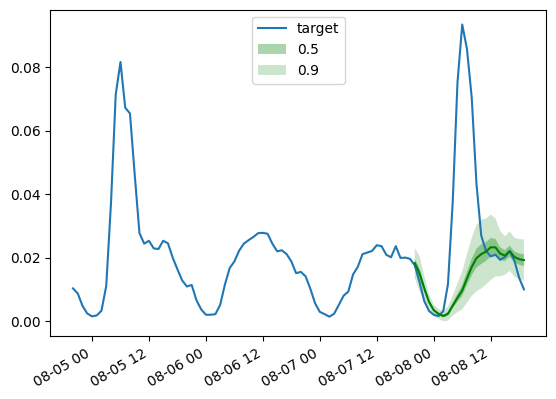

In [28]:
plot_gluonts(4)
